In [1]:
from main_transformation import TransformationPipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import pycountry
import missingno as msno
import seaborn as sns
import pycountry
import requests

In [2]:
# Style
sns.set_style("ticks",{'axes.grid' : True})

## General and basic data exploration

In [3]:
df_population, df_gapminder = TransformationPipeline().run()


----- compute Population for each country and each zone
Please, check the following list :
['Pre-demographic dividend', 'Sub-Saharan Africa (IDA & IBRD countries)', 'Europe & Central Asia', 'East Asia & Pacific (excluding high income)', 'St. Martin (French part)', 'Europe & Central Asia (excluding high income)', 'Heavily indebted poor countries (HIPC)', 'Pacific island small states', 'Least developed countries: UN classification', 'Latin America & Caribbean', 'IDA & IBRD total', 'Middle income', 'Isle of Man', 'Lower middle income', 'Sub-Saharan Africa', 'Africa Eastern and Southern', 'Early-demographic dividend', 'Other small states', 'Small states', 'West Bank and Gaza', 'Post-demographic dividend', 'Middle East & North Africa (excluding high income)', 'Upper middle income', 'Latin America & Caribbean (excluding high income)', 'South Asia', 'IBRD only', 'East Asia & Pacific', 'Channel Islands', 'Africa Western and Central', 'OECD members', 'Sint Maarten (Dutch part)', 'Euro area', '

c:\Users\Utilisateur\Documents\GitHub\shiftdataportal\data-preparation\src\transformation\demographic\population.py:60: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_gapminder = df_gapminder.applymap(lambda element: self.dirty_string_to_int(element))


In [4]:
def display_unique_values(s:pd.Series, df:pd.DataFrame):
    n_unique_values = df.loc[s.name, "nbr_unique_values"]
    if n_unique_values == 0:
        return "no value"
    if n_unique_values < 6:
        return ", ".join(f"{s.value_counts().index[i]} ({v} occurrences)" for i, v in enumerate(s.value_counts()))
    
    return "too many to display"


def add_additional_comment(s:pd.Series, df:pd.DataFrame, sensitivity:float):   
    value_counts = s.value_counts()

    if len(value_counts) > 0:
        # Calculate top common values based on sensitivity
        n_top_common_values = int(len(value_counts) * sensitivity)
        top_common_values = value_counts.values[:n_top_common_values]
        
        # Check if the top common values represent a significant proportion of the data
        if value_counts.quantile(1 - sensitivity) / value_counts.max() < 0.25 and n_top_common_values <= 10:
            sum_top_common_values = top_common_values.sum()
            top_common_values_prop = round(sum_top_common_values / df.loc[s.name, "nbr_non_null_values"], 2)
            top_common_values_info = [f"{value_counts.index[i]} ({value})" for i, value in enumerate(top_common_values)]
            
            # Print additional comments on common values
            return f"""First {n_top_common_values} unique values represent {top_common_values_prop * 100}% of total values : {', '.join(top_common_values_info)}"""
        
        return
    
    else:
        return "This column only contains null values."


def compute_modes(s:pd.Series):
    value_counts = s.value_counts()
    modes = s.mode()
    n_modes = len(modes)

    if n_modes > 0:
        return ", ".join(str(v) if i < 3 else f"... ({n_modes} elements)" for i, v in enumerate(modes[:min(n_modes, 4)])) + f" ({value_counts.values[0]} occurrence(s))"
    
    return


def get_df_variables_info(df:pd.DataFrame) -> pd.DataFrame:

    (n_rows, n_columns) = df.shape
    print(f"This DataFrame has {n_rows} rows and {n_columns} columns.")
    
    top_common_values_sensitivity = 0.15

    n_unique_values = df.nunique()
    n_values = df.count()

    df_info = pd.DataFrame({
        'column_type':df.dtypes,
        'missing_value_percentage': (df.isnull().mean()*100).round(3),
        'nbr_unique_values': n_unique_values,
        'nbr_null_values': df.isnull().sum(),
        'nbr_non_null_values': n_values,
        'duplicates_percentage':round(100-n_unique_values/(n_values.where(n_values != 0, np.nan))*100, 2),
        'mode': df.apply(compute_modes),
        'min': df.min(numeric_only=True),
        'max': df.max(numeric_only=True),
        'mean': df.mean(numeric_only=True),
        'median': df.median(numeric_only=True),
        'std': df.std(numeric_only=True)
        })

    df_info["unique_values"] = df.apply(display_unique_values, df=df_info)
    df_info["additional_comment"] = df.apply(add_additional_comment, df=df_info, sensitivity=top_common_values_sensitivity)

    return df_info


In [5]:
df_population_info = get_df_variables_info(df_population)

This DataFrame has 14400 rows and 4 columns.


In [6]:
df_gapminder_info = get_df_variables_info(df_gapminder)

This DataFrame has 46816 rows and 4 columns.


### Fix dtypes

In [7]:
df_gapminder["year"] = df_gapminder["year"].astype(int)
df_gapminder.reset_index(drop=True, inplace=True)

In [8]:
df_population["year"] = df_population["year"].astype(int)

In [9]:
df_population_info = get_df_variables_info(df_population)
df_gapminder_info = get_df_variables_info(df_gapminder)

This DataFrame has 14400 rows and 4 columns.
This DataFrame has 46816 rows and 4 columns.


### What countries are present in one source but not the other ?

In [57]:
def get_countries_diff(s1:set, s2:set, s1_name:str="set 1", s2_name:str="set 2"):
    diff = s2.difference(s1)
    diff = [i for i in diff if i is not None]
    n_diff = len(diff) 
    if n_diff > 0:
        print(f"{n_diff} countries are present in source '{s2_name}' but not in source '{s1_name}'.")
        return diff
    print(f"All countries present in source '{s2_name}' are also in source '{s1_name}'.")
    return 

In [11]:
get_countries_diff(s1=set(df_population["group_name"]), s2=set(df_gapminder["group_name"]), s1_name="WBD", s2_name="GapMinder")

Here are the countries present in source 'GapMinder' but not in source 'WBD' :
Vatican
Palestine
Taiwan


In [12]:
get_countries_diff(s1=set(df_gapminder["group_name"]), s2=set(df_population["group_name"]), s1_name="GapMinder", s2_name="WBD")

Here are the countries present in source 'WBD' but not in source 'GapMinder' :
Cayman Islands
Bermuda
Kosovo
Gibraltar
Greenland
American Samoa
Faeroe Islands
Aruba
Puerto Rico
Macao Special Administrative Region (China)
French Polynesia
United States Virgin Islands
New Caledonia
Guam
Northern Mariana Islands
British Virgin Islands
Curacao
Turks and Caicos Islands


We can assume that in GapMinder:

- United States data includes: Guam, Northern Mariana Islands, American Samoa, Puerto Rico, United States Virgin Islands
- Netherlands data includes: Aruba
- United Kingdom data includes: Gibraltar, Bermuda, British Virgin Islands, Cayman Islands, Turks and Caicos Islands
- France data includes: New Caledonia, French Polynesia
- Denmark data includes: Faroe Islands, Greenland
- China data includes: Macao Special Administrative Region (China)

However, there is no data on Kosovo

Finding reliable information on what data is actually included in each country for gapminder source seems quite complicated.

The best option seems to be maintaining both sources and aggregate them appropriately. Aggregating the data could lead to approximations and might not be ideal however.

## Compare both sources for common countries

In [13]:
common_countries = list(set(df_population["group_name"]) & set(df_gapminder["group_name"]))

In [14]:
df_population["source"] = "World Bank"
df_gapminder["source"] = "GapMinder"
combined_df = pd.concat([df_population, df_gapminder])

In [15]:
def diff_percent(s:pd.Series):
    if len(s) < 2:
        return 1
    values = s.values
    avg = np.mean(values)
    if avg == 0:
        return 0
    return 100*np.abs(values[1] - values[0])/avg

In [16]:
filtered_countries_years_cols_df = combined_df.loc[(combined_df["year"] >= 1960) & (combined_df["group_name"].isin(common_countries)), ["group_name", "year", "population"]]
df_difference = filtered_countries_years_cols_df.groupby(["group_name", "year"])["population"].apply(diff_percent).reset_index(name="population_diff_percent")
df_difference.reset_index(inplace=True)
df_mean_diff = df_difference.groupby("group_name")["population_diff_percent"].mean().sort_values(ascending=False)
df_mean_diff = df_mean_diff.reset_index()
combined_df = combined_df.merge(right=df_mean_diff, how="left", on="group_name").sort_values(by="population_diff_percent", ascending=False)

In [17]:
def wrapper(data:pd.DataFrame, **params):
    ax = plt.gca()
    diff_percentage = data["population_diff_percent"].mean()
    diff_text = AnchoredText(f"diff (%) : {round(diff_percentage, 2)}", loc="upper left")
    ax.add_artist(diff_text)

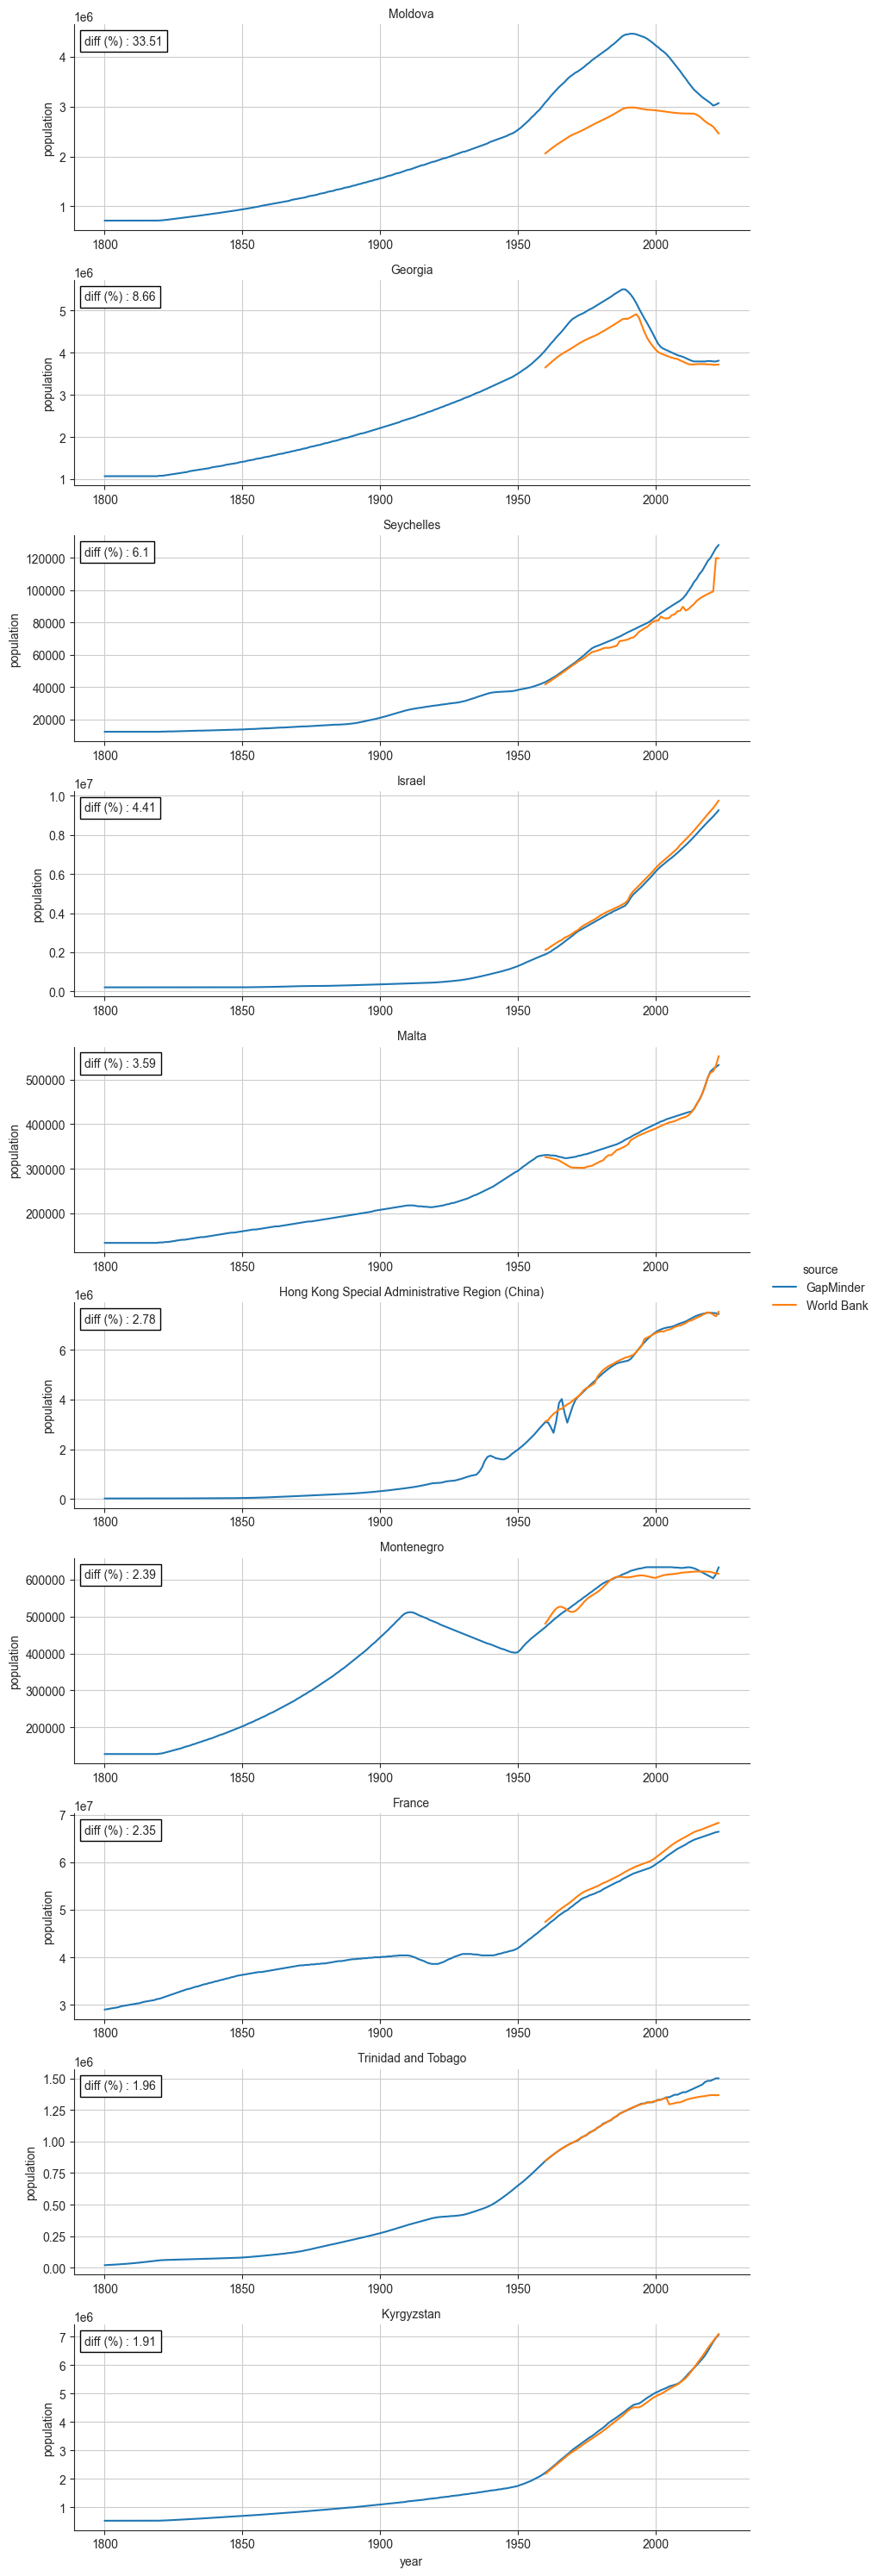

In [18]:
# countries_to_compare = ["Moldova"]
countries_to_compare = df_mean_diff["group_name"].iloc[:10]
filtered_countries_df = combined_df.loc[combined_df["group_name"].isin(countries_to_compare)]
g = sns.relplot(data=filtered_countries_df, height=3, aspect=3, x="year", y="population", row="group_name", hue="source", kind='line', facet_kws={"sharex":False, "sharey":False})
g.map_dataframe(func=wrapper)
g.set_titles(row_template="{row_name}")

## Get data from UN API

In [19]:
def callAPI(relative_path:str, **query_parameters) -> pd.DataFrame:
    base_url = "https://population.un.org/dataportalapi/api/v1"
    query_string_parameters = "&".join(f"{key}={value}" for key, value in query_parameters.items())
    target = f"{base_url}/{relative_path}?{query_string_parameters}"

    # Get the response, which includes the first page of data as well as information on pagination and number of records
    response = requests.get(target)

    # Loop until there are new pages with data
    while response.status_code != 404:
        j = response.json()
        
        #Store the result in a dataframe
        if isinstance(j, list):
            df_temp = pd.json_normalize(j)
        elif isinstance(j, dict):
            df_temp = pd.json_normalize(j['data'])
        else:
            raise TypeError("Response json type is not supported")
        
        # Prepare next page api call
        if "pageNumber" in query_parameters.keys():
            query_parameters["pageNumber"] += 1
        else:
            query_parameters["pageNumber"] = 2
        
        # Append next page to the data frame
        return pd.concat([df_temp, callAPI(relative_path, **query_parameters)])
    
    return None

In [20]:
locations = callAPI("locationsWithAggregates")

In [21]:
get_countries_diff(s1=set(locations["Name"]), s2=set(df_population["group_name"]), s1_name="UN", s2_name="WBD")

Here are the countries present in source 'WBD' but not in source 'UN' :
Persian Gulf
Cape Verde
Moldova
Curacao
Kosovo
North Korea
Faeroe Islands
Burma
Macao Special Administrative Region (China)
Hong Kong Special Administrative Region (China)
Asia and Oceania
Bolivia
Syria
Turkey
Iran
EU27
Laos
World
Eurasia
Tanzania
Macedonia
North America
Democratic Republic of the Congo
Ivory Coast
South Korea
Europe
Venezuela
Africa
Middle East
OECD
OPEC
Central and South America
Russian Federation & USSR


In [22]:
get_countries_diff(s2=set(locations["Name"]), s1=set(df_population["group_name"]), s2_name="UN", s1_name="WBD")

Here are the countries present in source 'UN' but not in source 'WBD' :
Cook Islands
Melanesia
China, Taiwan Province of China
Western Africa
Republic of Moldova
Dem. People's Rep. of Korea
Saint Helena
Low-income countries
Western Europe
Central and Southern Asia
Small island developing States (SIDS)
SIDS Atlantic, Indian Ocean and South China Sea (AIS)
Sub-Saharan Africa
Group B: Central and Southern Asia
Southern Europe
Kosovo (under UNSC res. 1244)
Curaçao
Group C: Eastern and South-Eastern Asia
Jersey
Group B – peaking (between 2025-2054)
Southern Asia
Saint Pierre and Miquelon
Lao People's Dem. Republic
Least developed countries
Saint Barthélemy
China, Macao SAR
Eastern Asia
Australia/New Zealand
Group C: Latin America and the Caribbean
Northern Europe
Central Asia
Faroe Islands
China, Hong Kong SAR
Western Asia
State of Palestine
Republic of Korea
Land-locked Developing Countries (LLDC)
Russian Federation
Oceania (excluding Australia and New Zealand)
SIDS Pacific
Martinique
East

## Add country codes

### Helper function to get country codes

In [24]:
def get_country_code(country_name:str):
    try:
        country = pycountry.countries.search_fuzzy(country_name)
        return country[0].alpha_3
    except:
        return None

In [26]:
mapping_dict = {}
for c in df_population["group_name"].unique():
    mapping_dict[c]= get_country_code(c)

Afghanistan
Albania
Algeria
American Samoa
Andorra
Angola
Antigua and Barbuda
Argentina
Armenia
Aruba
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bermuda
Bhutan
Bolivia
Bosnia and Herzegovina
Botswana
Brazil
British Virgin Islands
Brunei Darussalam
Bulgaria
Burkina Faso
Burma
Burundi
Cambodia
Cameroon
Canada
Cape Verde
Cayman Islands
Central African Republic
Chad
Chile
China
Colombia
Comoros
Congo
Costa Rica
Croatia
Cuba
Curacao
Cyprus
Czechia
Democratic Republic of the Congo
Denmark
Djibouti
Dominica
Dominican Republic
Ecuador
Egypt
El Salvador
Equatorial Guinea
Eritrea
Estonia
Eswatini
Ethiopia
Faeroe Islands
Fiji
Finland
France
French Polynesia
Gabon
Gambia
Georgia
Germany
Ghana
Gibraltar
Greece
Greenland
Grenada
Guam
Guatemala
Guinea
Guinea-Bissau
Guyana
Haiti
Honduras
Hong Kong Special Administrative Region (China)
Hungary
Iceland
India
Indonesia
Iran
Iraq
Ireland
Israel
Italy
Ivory Coast
Jamaica
Japan
Jordan
Kazakhstan
Kenya
Kirib

In [ ]:
df_population["country_code"] = df_population["group_name"].map(mapping_dict)
df_population.loc[df_population["country_code"].isna(), "group_name"].unique()

In [37]:
mapping_dict["Burma"] = "MMR"
mapping_dict["Cape Verde"] = "CPV"
mapping_dict["Democratic Republic of the Congo"] = "COD"
mapping_dict["Faeroe Islands"] = "FRO"
mapping_dict["Hong Kong Special Administrative Region (China)"] = "HKG"
mapping_dict["Ivory Coast"] = "CIV"
mapping_dict["Laos"] = "LAO"
mapping_dict["Macao Special Administrative Region (China)"] = "MAC"
mapping_dict["Russian Federation & USSR"] = "RUS"
mapping_dict["United States Virgin Islands"] = "VIR"

In [58]:
countries_list = get_countries_diff(s2=set(locations["Iso3"]), s1=set(df_population["country_code"]), s2_name="UN", s1_name="WBD")

98 countries are present in source 'UN' but not in source 'WBD'.


In [66]:
# After removing areas with no coordinates
exceptions = ["XKX", "BLM", "MAF", "JEY", "GGY"]
countries_list = get_countries_diff(s2=set(locations.loc[locations["Longitude"].notna() | (locations["Iso3"].isin(exceptions)), "Iso3"]), s1=set(df_population["country_code"]), s2_name="UN", s1_name="WBD") 

28 countries are present in source 'UN' but not in source 'WBD'.


In [67]:
locations.loc[locations["Iso3"].isin(countries_list), "Name"]

41     China, Taiwan Province of China
44                             Mayotte
47                        Cook Islands
64         Falkland Islands (Malvinas)
68                       French Guiana
74                  State of Palestine
82                          Guadeloupe
88                            Holy See
8        Kosovo (under UNSC res. 1244)
27                          Martinique
35                          Montserrat
43                             Curaçao
45           Sint Maarten (Dutch part)
46    Bonaire, Sint Eustatius and Saba
51                               Niger
53                                Niue
71                             Réunion
75                    Saint Barthélemy
76                        Saint Helena
78                            Anguilla
80          Saint Martin (French part)
81           Saint Pierre and Miquelon
0                       Western Sahara
9                              Tokelau
23                            Guernsey
24                       